# ドル指数 月足 メジアン統計

In [22]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pingouin as pg
import seaborn as sns
import yfinance as yf

In [23]:
code = 'DX-Y.NYB'
symbol = code
ticker = yf.Ticker(symbol)

In [24]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='max', interval='1mo')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y =  datetime.timedelta(days=365 * 10)
df = df0[df0.index >= dt_last - tdelta_3y]
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-05-01 00:00:00-04:00,94.830002,97.779999,93.129997,96.910004,0,0.0,0.0
2015-06-01 00:00:00-04:00,96.889999,97.680000,93.559998,95.489998,0,0.0,0.0
2015-07-01 00:00:00-04:00,95.599998,98.150002,95.449997,97.370003,0,0.0,0.0
2015-08-01 00:00:00-04:00,97.220001,98.330002,92.620003,95.949997,0,0.0,0.0
2015-09-01 00:00:00-04:00,95.930000,96.699997,94.059998,96.349998,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-01 00:00:00-05:00,105.820000,108.580002,105.419998,108.489998,0,0.0,0.0
2025-01-01 00:00:00-05:00,108.529999,110.180000,106.970001,108.370003,0,0.0,0.0
2025-02-01 00:00:00-05:00,108.500000,109.879997,106.129997,107.610001,0,0.0,0.0


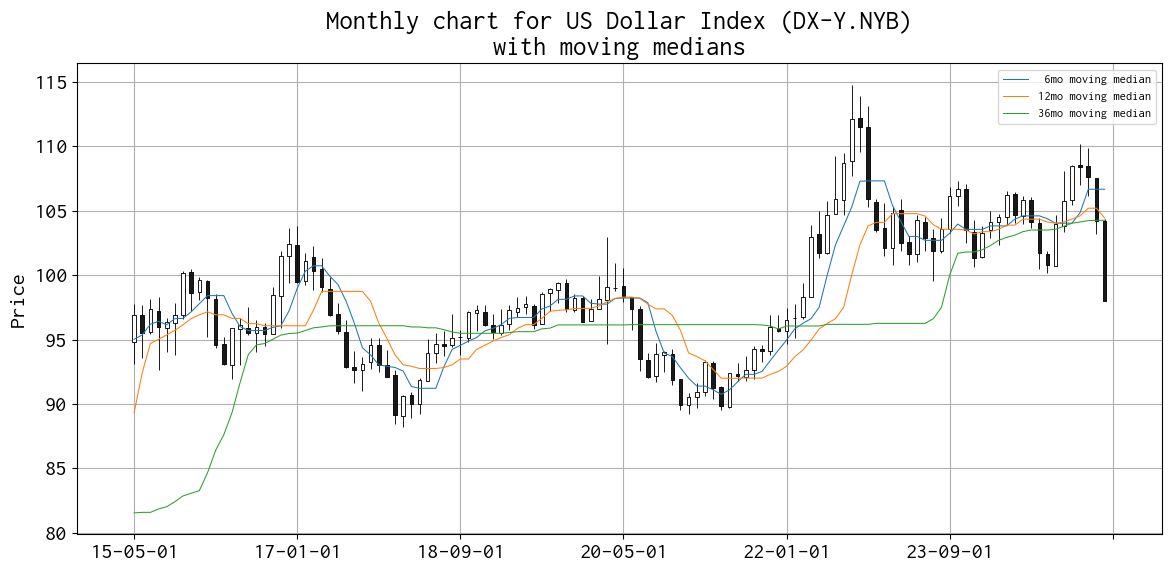

In [25]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

mm06 = df0['Close'].rolling(6).median()
mm12 = df0['Close'].rolling(12).median()
mm36 = df0['Close'].rolling(36).median()
apds  = [
    mpf.make_addplot(mm06[df.index], width=0.75, label=' 6mo moving median', ax=ax),
    mpf.make_addplot(mm12[df.index], width=0.75, label='12mo moving median', ax=ax),
    mpf.make_addplot(mm36[df.index], width=0.75, label='36mo moving median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=False,
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Monthly chart for %s (%s)\nwith moving medians' % (ticker.info['longName'], symbol))

ax.legend(loc='best', fontsize=9)
ax.grid()

plt.tight_layout()
plt.savefig('report_monthly_chart_robust_%s.png' % code)
plt.show()

In [26]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-01 00:00:00-04:00,104.18,104.370003,97.983002,97.997002,0,0.0,0.0


In [27]:
df.tail(2)['Close']

Date
2025-03-01 00:00:00-05:00    104.209999
2025-04-01 00:00:00-04:00     97.997002
Name: Close, dtype: float64

In [28]:
df.tail(2)['Close'].diff()

Date
2025-03-01 00:00:00-05:00         NaN
2025-04-01 00:00:00-04:00   -6.212997
Name: Close, dtype: float64

## Robust Bollinger bands

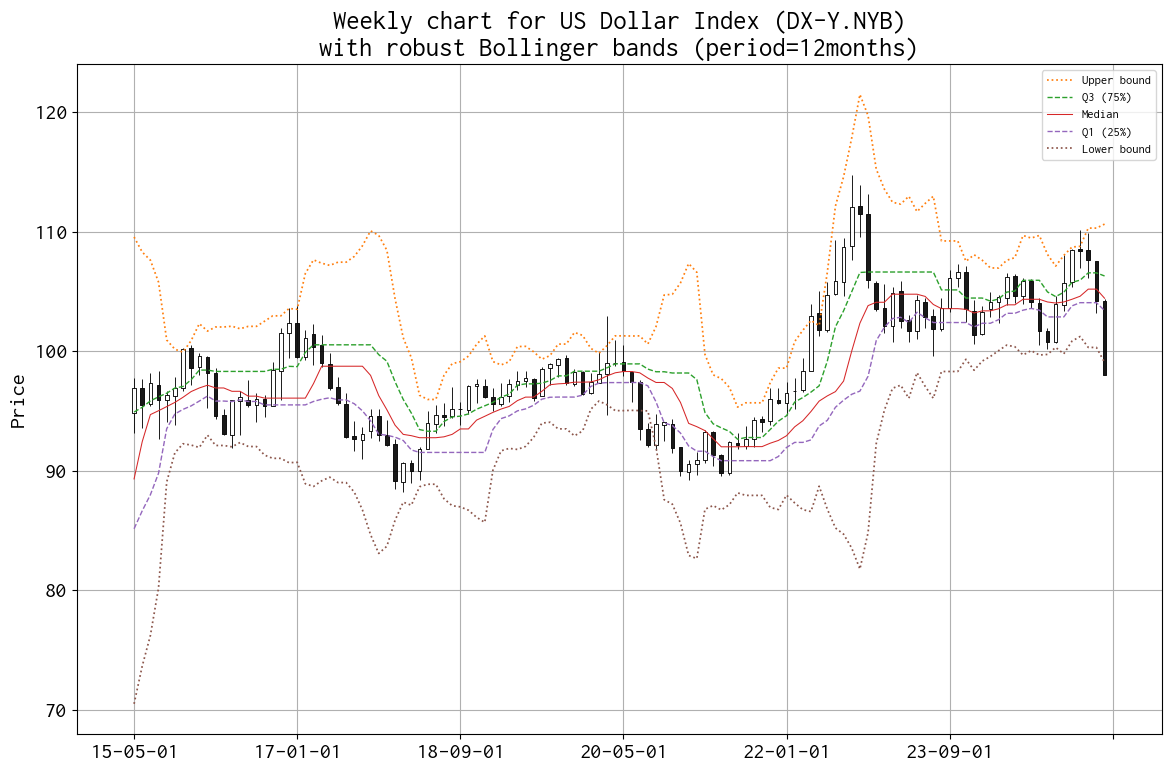

In [29]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 12
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dmonths)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%smonths)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_monthly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

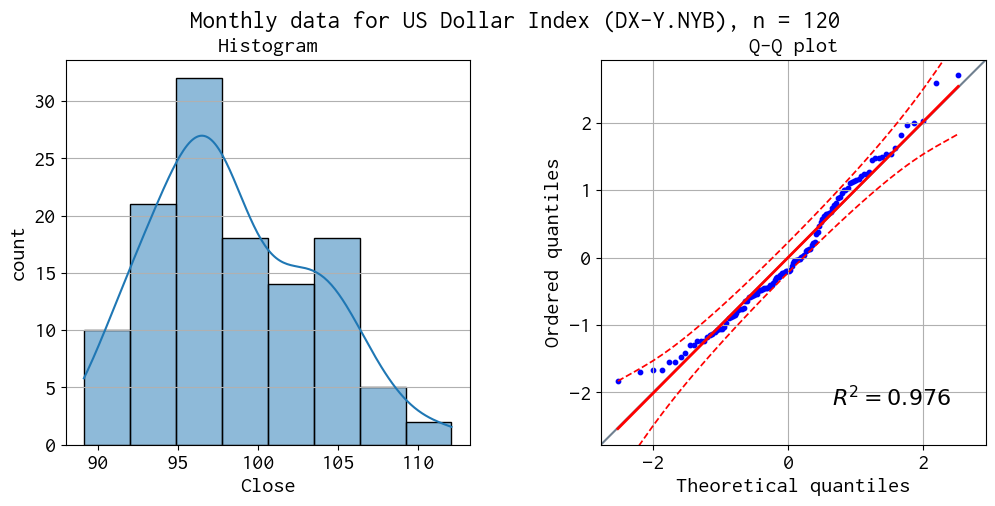

In [30]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Monthly data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_monthly_histogram_qqplot_%s.png' % code)
plt.show()